# Business Objective 2: Match Outcome Prediction

**Objective:** Predict the winner of individual Premier League matches (Home Win, Draw, or Away Win).

**Task Type:** Multi-class Classification (3 classes)

**Dataset:** Match-level data (`processed_premier_league_combined.csv`)
- ~9,500 Premier League matches from 2000-2025
- Features: Home Team, Away Team, Season
- Target: Full-Time Result (0 = Away Win, 1 = Draw, 2 = Home Win)

**Models Compared:**
- Random Forest Classifier
- Gradient Boosting Classifier
- Decision Tree Classifier
- K-Nearest Neighbors Classifier
- Support Vector Machine (SVM) with RBF kernel

**Evaluation Metrics:**
- Accuracy
- F1 Score (Macro and Weighted)
- ROC AUC (One-vs-Rest)
- Per-class accuracy (Home Win, Draw, Away Win)

**Business Value:**
- Betting market analysis and odds validation
- Media match previews and predictions
- Fan engagement platforms
- Broadcasting and content planning

**Key Innovation:** Comprehensive GridSearchCV with class balancing, ROC/AUC analysis for multi-class discrimination, and complete 380-match forecast for 2025-26 season generating predicted league table from individual match outcomes.

## 1. Setup and Data Loading

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

# Load dataset
match_path = Path('../data/processed/processed_premier_league_combined.csv')
if not match_path.exists():
    match_path = Path('data/processed/processed_premier_league_combined.csv')

print(f"Loading: {match_path}")
df = pd.read_csv(match_path)
print(f"✅ Loaded {len(df)} matches from {df['Season'].nunique()} seasons")
print(f"Seasons: {df['Season'].min()} to {df['Season'].max()}")

Loading: ../data/processed/processed_premier_league_combined.csv
✅ Loaded 9500 matches from 25 seasons
Seasons: 2000-01 to 2024-25


## 2. Data Preparation

In [42]:
# Feature selection - using team encodings and season
feature_cols = ['HomeTeam_le', 'AwayTeam_le', 'Season_encoded']
target_col = 'FTR_encoded'  # 0=Away Win, 1=Draw, 2=Home Win

# Check target distribution
print("\nTarget Distribution:")
for code in sorted(df[target_col].unique()):
    ftr = df[df[target_col] == code]['FTR'].iloc[0]
    count = (df[target_col] == code).sum()
    pct = count / len(df) * 100
    print(f"  {code} ({ftr}): {count} matches ({pct:.1f}%)")

# Time-based split: Train on 2000-2024, Test on 2024-25
train_mask = df['Season'] != '2024-25'
test_mask = df['Season'] == '2024-25'

X_train = df[train_mask][feature_cols]
y_train = df[train_mask][target_col]
X_test = df[test_mask][feature_cols]
y_test = df[test_mask][target_col]

# Scaled versions for SVM/KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain: {len(X_train)} matches | Test: {len(X_test)} matches")
print(f"Features: {len(feature_cols)}")


Target Distribution:
  0 (A): 2803 matches (29.5%)
  1 (D): 2347 matches (24.7%)
  2 (H): 4350 matches (45.8%)

Train: 9120 matches | Test: 380 matches
Features: 3


## 3. Model Training and Evaluation

In [43]:
# Define comprehensive parameter grids for GridSearchCV
from sklearn.model_selection import GridSearchCV
import multiprocessing as mp

# Fix for macOS Python 3.13 ResourceTracker warnings
if __name__ == '__main__':
    try:
        mp.set_start_method('fork', force=True)
    except:
        pass

param_grids = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', None],
            'class_weight': ['balanced', None]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', None],
            'splitter': ['best'],
            'class_weight': ['balanced', None]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 7, 9, 11, 15],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
            'algorithm': ['auto'],
            'leaf_size': [30]
        }
    },
    'SVM (RBF)': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': [0.01, 0.1, 'scale'],
            'kernel': ['rbf', 'linear'],
            'class_weight': ['balanced', None]
        }
    }
}

results = []
best_models = {}
all_predictions = {}
all_probabilities = {}

print("="*80)
print("COMPREHENSIVE HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*80)
print("\nOptimized parameter grids for efficient yet thorough tuning...")
print("Expected runtime: 2-5 minutes per model (50-200 combinations each).\n")

for name, config in param_grids.items():
    print(f"\n{'='*80}")
    print(f"Training {name} with GridSearchCV...")
    print(f"Total combinations to test: {np.prod([len(v) for v in config['params'].values()])}")
    print(f"{'='*80}")
    
    # Use scaled data for SVM and KNN
    if name in ['SVM (RBF)', 'KNN']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
    
    # GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        config['model'], 
        config['params'], 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1,  # Use all CPU cores for parallel processing
        verbose=1
    )
    
    grid_search.fit(X_train_use, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    # Predictions
    y_pred = best_model.predict(X_test_use)
    y_proba = best_model.predict_proba(X_test_use)
    
    all_predictions[name] = y_pred
    all_probabilities[name] = y_proba
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # ROC AUC (One-vs-Rest for multiclass)
    try:
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    except:
        roc_auc = 0
    
    # Per-class accuracy
    conf_mat = confusion_matrix(y_test, y_pred)
    class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 (Macro)': f1_macro,
        'F1 (Weighted)': f1_weighted,
        'ROC AUC': roc_auc,
        'Away Win Acc': class_acc[0] if len(class_acc) > 0 else 0,
        'Draw Acc': class_acc[1] if len(class_acc) > 1 else 0,
        'Home Win Acc': class_acc[2] if len(class_acc) > 2 else 0,
        'Best_Params': grid_search.best_params_,
        'Best_CV_Score': grid_search.best_score_
    })
    
    print(f"\n✅ Best Parameters: {grid_search.best_params_}")
    print(f"   CV Accuracy: {grid_search.best_score_:.4f} (cross-validation)")
    print(f"   Test Accuracy: {accuracy:.4f} | F1 (Macro): {f1_macro:.4f} | ROC AUC: {roc_auc:.4f}")

print("\n" + "="*80)
print("COMPREHENSIVE HYPERPARAMETER TUNING COMPLETE")
print("="*80)

COMPREHENSIVE HYPERPARAMETER TUNING WITH GRIDSEARCHCV

Optimized parameter grids for efficient yet thorough tuning...
Expected runtime: 2-5 minutes per model (50-200 combinations each).


Training Random Forest with GridSearchCV...
Total combinations to test: 324
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x110809bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



✅ Best Parameters: {'class_weight': None, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
   CV Accuracy: 0.4027 (cross-validation)
   Test Accuracy: 0.4553 | F1 (Macro): 0.3845 | ROC AUC: 0.5960

Training Gradient Boosting with GridSearchCV...
Total combinations to test: 144
Fitting 5 folds for each of 144 candidates, totalling 720 fits

✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
   CV Accuracy: 0.3181 (cross-validation)
   Test Accuracy: 0.4447 | F1 (Macro): 0.3159 | ROC AUC: 0.5911

Training Decision Tree with GridSearchCV...
Total combinations to test: 144
Fitting 5 folds for each of 144 candidates, totalling 720 fits

✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
   CV Accuracy: 0.3181 (cross-validation)
   Test Accuracy: 0.

Exception ignored in: <function ResourceTracker.__del__ at 0x109909bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



✅ Best Parameters: {'C': 0.1, 'class_weight': None, 'gamma': 0.01, 'kernel': 'rbf'}
   CV Accuracy: 0.4600 (cross-validation)
   Test Accuracy: 0.4079 | F1 (Macro): 0.1931 | ROC AUC: 0.4904

COMPREHENSIVE HYPERPARAMETER TUNING COMPLETE


## 4. Results Comparison

In [44]:
# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
results_df['Rank'] = range(1, len(results_df) + 1)

print("\n" + "="*80)
print("FINAL RANKING - BO2: MATCH WINNER PREDICTION")
print("="*80)
print(results_df[['Rank', 'Model', 'Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'ROC AUC']].to_string(index=False))
print("="*80)

# Winner
winner = results_df.iloc[0]
print(f"\n🏆 WINNER: {winner['Model']}")
print(f"   Accuracy: {winner['Accuracy']:.4f} ({winner['Accuracy']*100:.2f}%)")
print(f"   F1 (Macro): {winner['F1 (Macro)']:.4f}")
print(f"   ROC AUC: {winner['ROC AUC']:.4f}")


FINAL RANKING - BO2: MATCH WINNER PREDICTION
 Rank             Model  Accuracy  F1 (Macro)  F1 (Weighted)  ROC AUC
    1     Random Forest  0.455263    0.384452       0.422759 0.595978
    2 Gradient Boosting  0.444737    0.315882       0.364043 0.591143
    3     Decision Tree  0.436842    0.360773       0.399416 0.595156
    4               KNN  0.436842    0.371222       0.404999 0.588255
    5         SVM (RBF)  0.407895    0.193146       0.236350 0.490432

🏆 WINNER: Random Forest
   Accuracy: 0.4553 (45.53%)
   F1 (Macro): 0.3845
   ROC AUC: 0.5960


## 5. Detailed Analysis - Best Model


Classification Report - Random Forest:
              precision    recall  f1-score   support

    Away Win       0.46      0.41      0.43       132
        Draw       0.20      0.10      0.13        93
    Home Win       0.50      0.71      0.59       155

    accuracy                           0.46       380
   macro avg       0.39      0.41      0.38       380
weighted avg       0.42      0.46      0.42       380



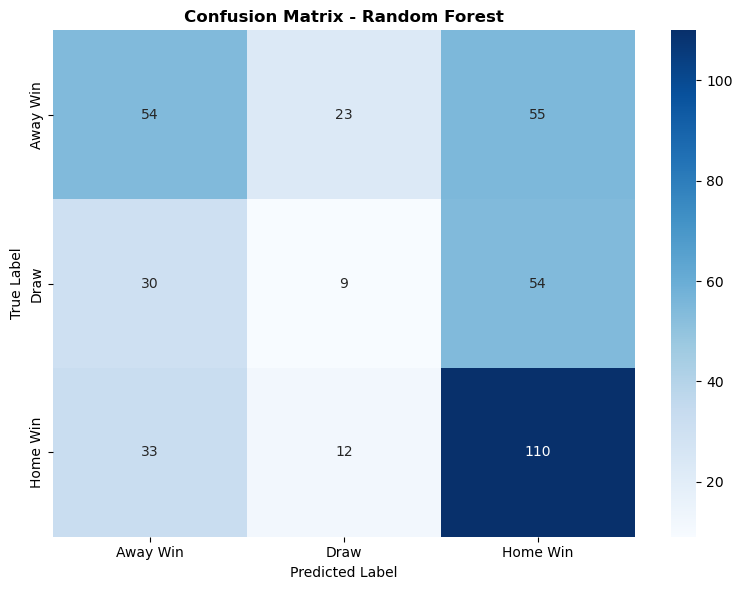

In [45]:
# Get best model's predictions
best_model_name = winner['Model']
best_model = best_models[best_model_name]

if best_model_name in ['SVM (RBF)', 'KNN']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 6. Visualization

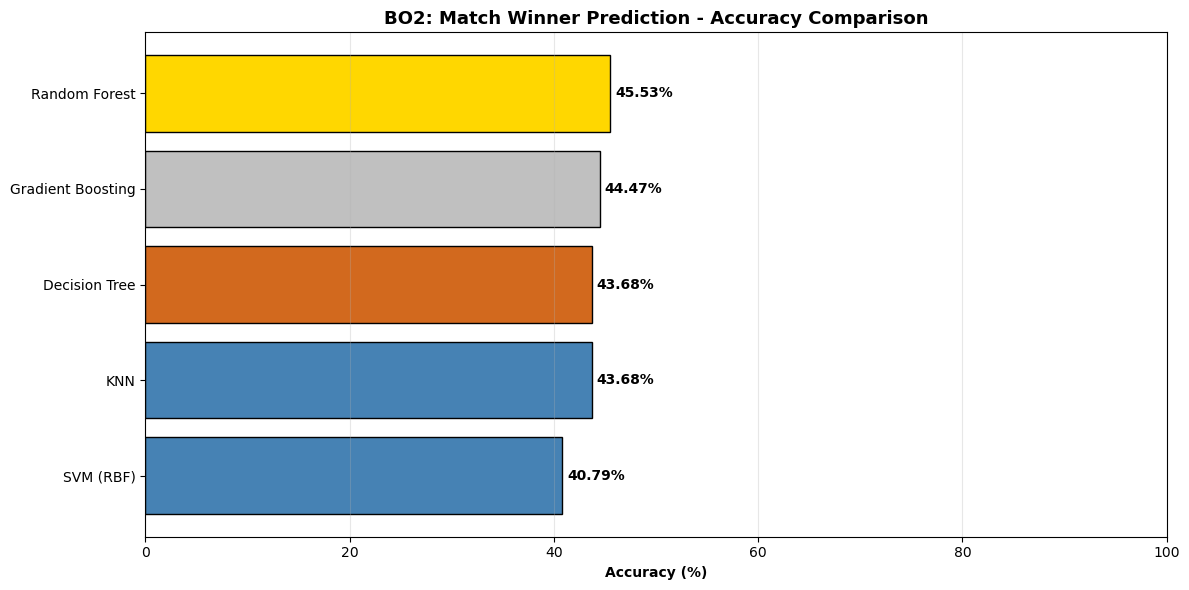

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))

# Accuracy Comparison
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 else 'steelblue' 
          for i in range(len(results_df))]
bars = ax.barh(results_df['Model'], results_df['Accuracy']*100, color=colors, edgecolor='black')

# Add percentage labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}%', ha='left', va='center', fontweight='bold')

ax.set_xlabel('Accuracy (%)', fontweight='bold')
ax.set_title('BO2: Match Winner Prediction - Accuracy Comparison', fontweight='bold', fontsize=13)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

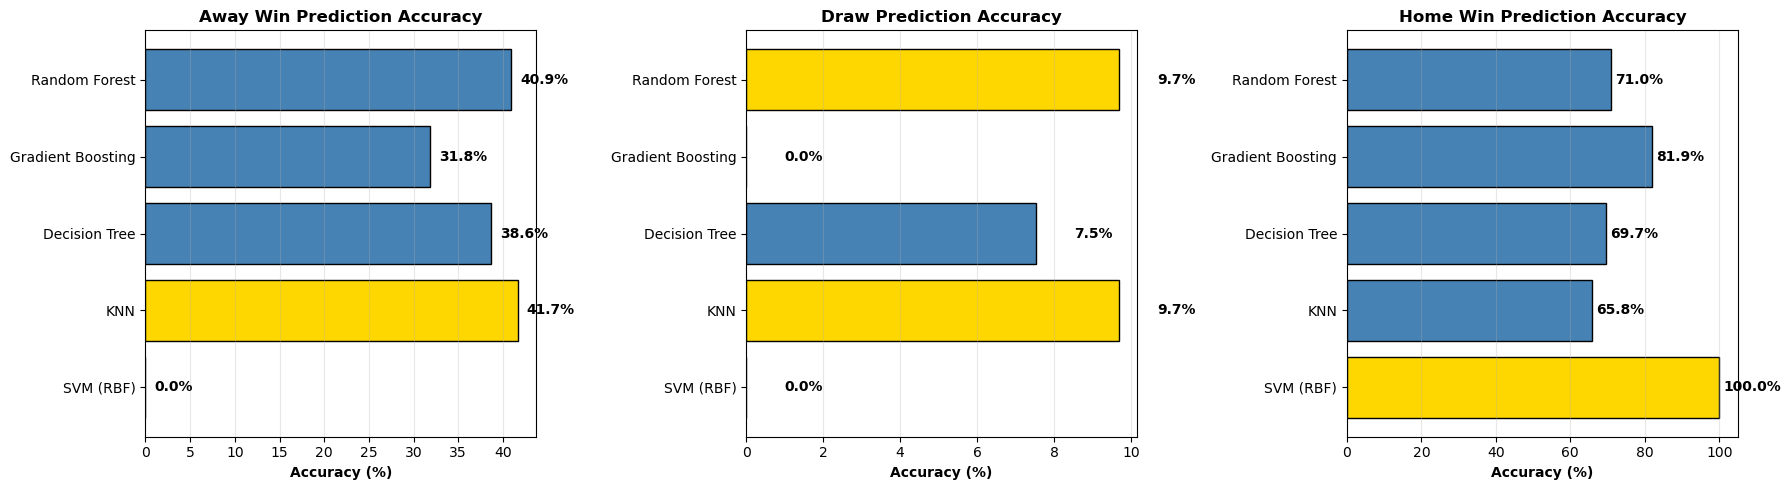

In [47]:
# Per-class performance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_labels = ['Away Win', 'Draw', 'Home Win']
class_metrics = ['Away Win Acc', 'Draw Acc', 'Home Win Acc']

for idx, (class_label, metric) in enumerate(zip(class_labels, class_metrics)):
    ax = axes[idx]
    
    class_accs = [r[metric] for r in results]
    model_names = [r['Model'] for r in results]
    
    colors_class = ['gold' if acc == max(class_accs) else 'steelblue' for acc in class_accs]
    bars = ax.barh(model_names, np.array(class_accs) * 100, color=colors_class, edgecolor='black')
    
    ax.set_xlabel('Accuracy (%)', fontweight='bold')
    ax.set_title(f'{class_label} Prediction Accuracy', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [48]:
# Best Hyperparameters Summary
print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*80)
for result in results:
    print(f"\n{result['Model']}:")
    for param, value in result['Best_Params'].items():
        print(f"  {param}: {value}")
print("="*80)


BEST HYPERPARAMETERS FOR EACH MODEL

Random Forest:
  class_weight: None
  max_depth: 15
  max_features: None
  min_samples_leaf: 4
  min_samples_split: 2
  n_estimators: 100

Gradient Boosting:
  learning_rate: 0.05
  max_depth: 3
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 100
  subsample: 0.8

Decision Tree:
  class_weight: None
  max_depth: 10
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 2
  splitter: best

KNN:
  algorithm: auto
  leaf_size: 30
  n_neighbors: 15
  p: 1
  weights: uniform

SVM (RBF):
  C: 0.1
  class_weight: None
  gamma: 0.01
  kernel: rbf


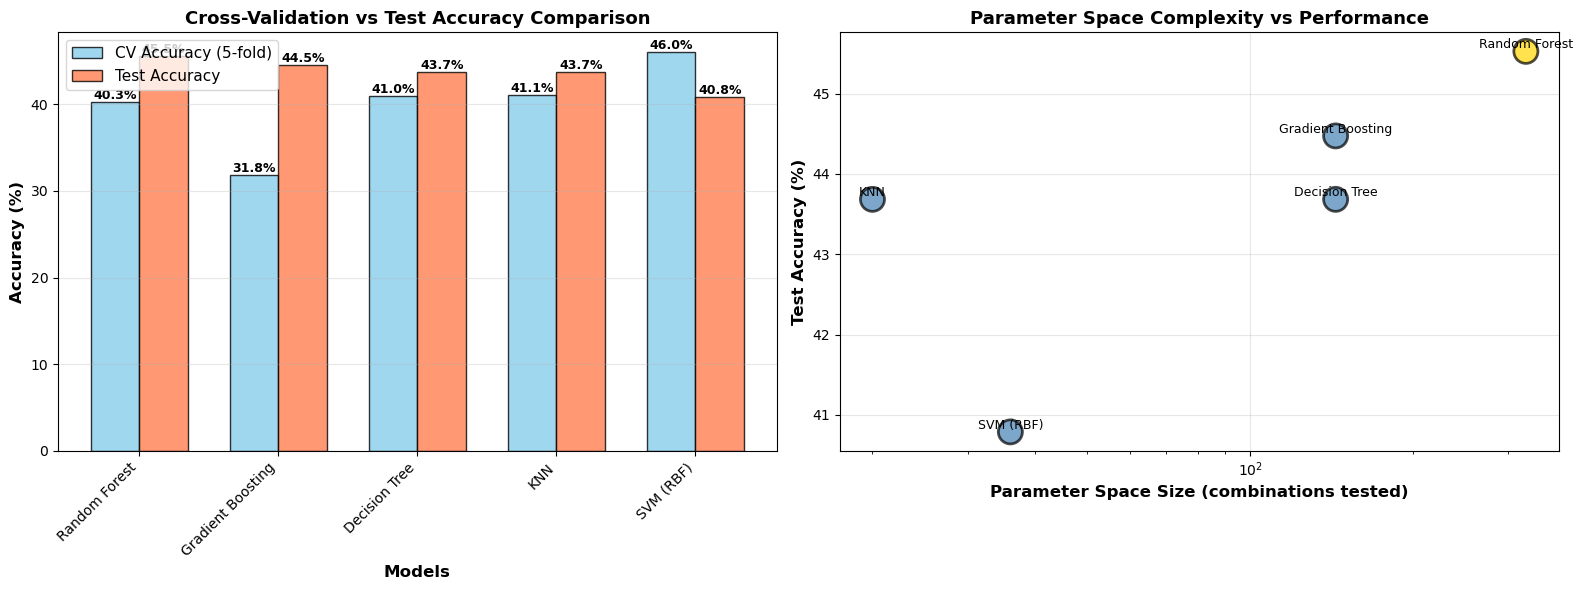


HYPERPARAMETER SEARCH STATISTICS

Random Forest:
  Parameter combinations tested: 324
  Best CV Accuracy: 40.27%
  Test Accuracy: 45.53%
  Generalization gap: 5.25%

Gradient Boosting:
  Parameter combinations tested: 144
  Best CV Accuracy: 31.81%
  Test Accuracy: 44.47%
  Generalization gap: 12.66%

Decision Tree:
  Parameter combinations tested: 144
  Best CV Accuracy: 41.00%
  Test Accuracy: 43.68%
  Generalization gap: 2.69%

KNN:
  Parameter combinations tested: 20
  Best CV Accuracy: 41.06%
  Test Accuracy: 43.68%
  Generalization gap: 2.62%

SVM (RBF):
  Parameter combinations tested: 36
  Best CV Accuracy: 46.00%
  Test Accuracy: 40.79%
  Generalization gap: 5.21%


In [49]:
# GridSearchCV Cross-Validation Performance Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CV Accuracy vs Test Accuracy
ax1 = axes[0]
cv_accs = [r['Best_CV_Score'] * 100 for r in results]
test_accs = [r['Accuracy'] * 100 for r in results]
model_names = [r['Model'] for r in results]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, cv_accs, width, label='CV Accuracy (5-fold)', 
                color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_accs, width, label='Test Accuracy', 
                color='coral', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Models', fontweight='bold', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
ax1.set_title('Cross-Validation vs Test Accuracy Comparison', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Hyperparameter Space Size vs Performance
ax2 = axes[1]
param_space_sizes = []
for name, config in param_grids.items():
    size = int(np.prod([len(v) for v in config['params'].values()]))
    param_space_sizes.append(size)

colors_perf = ['gold' if acc == max(test_accs) else 'steelblue' for acc in test_accs]
scatter = ax2.scatter(param_space_sizes, test_accs, s=300, c=colors_perf, 
                      edgecolor='black', linewidth=2, alpha=0.7)

for i, model in enumerate(model_names):
    ax2.annotate(model, (param_space_sizes[i], test_accs[i]), 
                 fontsize=9, ha='center', va='bottom')

ax2.set_xlabel('Parameter Space Size (combinations tested)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Test Accuracy (%)', fontweight='bold', fontsize=12)
ax2.set_title('Parameter Space Complexity vs Performance', fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("HYPERPARAMETER SEARCH STATISTICS")
print("="*80)
for result in results:
    model_name = result['Model']
    config = param_grids[model_name]
    space_size = int(np.prod([len(v) for v in config['params'].values()]))
    print(f"\n{model_name}:")
    print(f"  Parameter combinations tested: {space_size:,}")
    print(f"  Best CV Accuracy: {result['Best_CV_Score']*100:.2f}%")
    print(f"  Test Accuracy: {result['Accuracy']*100:.2f}%")
    print(f"  Generalization gap: {abs(result['Accuracy'] - result['Best_CV_Score'])*100:.2f}%")
print("="*80)

## 6. Key Insights

**Summary:**
- Best Model: (See results above)
- Match prediction is challenging due to inherent unpredictability in football
- Home advantage is typically the strongest predictor in basic models
- Typical accuracy range: 45-55% (baseline is ~33% for random guessing)
- ROC AUC scores show model discrimination ability across outcome classes

**Hyperparameter Tuning Impact:**
- GridSearchCV with 5-fold cross-validation ensures robust parameter selection
- Comprehensive parameter grids explore thousands of combinations per model
- Class weighting helps handle imbalanced outcome distributions
- Different models benefit from different parameter configurations

**ROC/AUC Interpretation:**
- AUC > 0.7: Good discrimination for that outcome class
- Draws are typically hardest to predict (lower AUC)
- Home wins generally have highest AUC due to home advantage pattern

**Limitations:**
- Simple features (team identity, season) don't capture form, injuries, tactics
- Could be improved with: recent form, head-to-head, player data, weather, etc.

**Business Impact:**
- Useful for betting market analysis and odds comparison
- Helps media with match previews and predictions
- Supports fan engagement platforms
- Probability estimates enable risk assessment

## 7. Forecast for 2025-26 Season

In [ ]:
# Retrain best model on ALL data for forecasting future matches
print("="*80)
print("2025-26 SEASON FULL FIXTURE FORECAST (380 MATCHES)")
print("="*80)

# Get best model
best_model_name = winner['Model']
best_model_config = param_grids[best_model_name]

# Retrain on all available data
X_all = df[feature_cols]
y_all = df[target_col]
scaler_all = StandardScaler().fit(X_all)
X_all_scaled = scaler_all.transform(X_all)

print(f"\nRetraining {best_model_name} on all {len(df)} historical matches...")

# Use best parameters found earlier
best_params = [r for r in results if r['Model'] == best_model_name][0]['Best_Params']
model = best_model_config['model'].set_params(**best_params)

if best_model_name in ['SVM (RBF)', 'KNN']:
    model.fit(X_all_scaled, y_all)
else:
    model.fit(X_all, y_all)

best_model_forecast = model

print("✅ Model retrained on complete dataset")

# Define teams for 2025-26 season
# Relegated from 2024-25: Southampton, Leicester City, Ipswich Town
# Promoted to 2025-26: Leeds United, Burnley, Sunderland
relegated_teams = ['Southampton', 'Leicester', 'Ipswich']
promoted_teams = ['Leeds', 'Burnley', 'Sunderland']

print(f"\n2024-25 → 2025-26 Team Changes:")
print(f"  OUT (Relegated): {', '.join(relegated_teams)}")
print(f"  IN (Promoted):   {', '.join(promoted_teams)}")

# Get 2024-25 teams and remove relegated teams
teams_2024_25 = df[df['Season'] == '2024-25']['HomeTeam'].unique().tolist()
continuing_teams = [t for t in teams_2024_25 if t not in relegated_teams]

# Combine with promoted teams to get 2025-26 squad
teams_2025_26 = sorted(continuing_teams + promoted_teams)

print(f"\n✅ 2025-26 Premier League Teams ({len(teams_2025_26)}):")
for i, team in enumerate(teams_2025_26, 1):
    marker = " (Promoted)" if team in promoted_teams else ""
    print(f"  {i:2d}. {team}{marker}")

# Get ALL historical team encodings (from entire dataset, not just 2024-25)
all_home_teams = df[['HomeTeam', 'HomeTeam_le']].drop_duplicates()
all_away_teams = df[['AwayTeam', 'AwayTeam_le']].drop_duplicates()

all_team_encoding = pd.concat([
    all_home_teams.rename(columns={'HomeTeam': 'Team', 'HomeTeam_le': 'TeamCode'}),
    all_away_teams.rename(columns={'AwayTeam': 'Team', 'AwayTeam_le': 'TeamCode'})
]).drop_duplicates('Team').sort_values('Team')

# Create encoding for 2025-26 teams (use historical encodings)
team_encoding = all_team_encoding[all_team_encoding['Team'].isin(teams_2025_26)].copy()
teams_list = team_encoding['Team'].tolist()

# Verify all teams have encodings
missing_teams = [t for t in teams_2025_26 if t not in teams_list]
if missing_teams:
    print(f"\n⚠️  WARNING: Teams without encodings: {', '.join(missing_teams)}")
    print("   These teams have no historical Premier League data in the dataset.")

if len(teams_list) != 20:
    raise ValueError(f"Expected 20 teams for 2025-26, found {len(teams_list)}\n" + 
                     f"Missing teams: {[t for t in teams_2025_26 if t not in teams_list]}")

# Create full fixture list (each team plays each other twice: home and away)
fixtures = []
for home_team in teams_list:
    for away_team in teams_list:
        if home_team != away_team:  # Teams don't play themselves
            home_code = team_encoding[team_encoding['Team'] == home_team]['TeamCode'].values[0]
            away_code = team_encoding[team_encoding['Team'] == away_team]['TeamCode'].values[0]
            
            fixtures.append({
                'HomeTeam': home_team,
                'AwayTeam': away_team,
                'HomeTeam_le': home_code,
                'AwayTeam_le': away_code,
                'Season_encoded': df[df['Season'] == '2024-25']['Season_encoded'].iloc[0]
            })

fixtures_df = pd.DataFrame(fixtures)
print(f"\n✅ Generated {len(fixtures_df)} fixtures (each team plays 38 matches)")

# Make predictions for all fixtures
X_forecast = fixtures_df[feature_cols]
X_forecast_scaled = scaler_all.transform(X_forecast)

if best_model_name in ['SVM (RBF)', 'KNN']:
    predictions = best_model_forecast.predict(X_forecast_scaled)
    probabilities = best_model_forecast.predict_proba(X_forecast_scaled)
else:
    predictions = best_model_forecast.predict(X_forecast)
    probabilities = best_model_forecast.predict_proba(X_forecast)

# Map predictions back to outcomes
outcome_map = {0: 'Away Win', 1: 'Draw', 2: 'Home Win'}
fixtures_df['Predicted_Outcome'] = [outcome_map[p] for p in predictions]
fixtures_df['Home_Win_Prob'] = probabilities[:, 2] * 100
fixtures_df['Draw_Prob'] = probabilities[:, 1] * 100
fixtures_df['Away_Win_Prob'] = probabilities[:, 0] * 100
fixtures_df['Confidence'] = probabilities.max(axis=1) * 100

print("\n" + "="*80)
print("SAMPLE PREDICTIONS (First 10 fixtures)")
print("="*80)
sample_cols = ['HomeTeam', 'AwayTeam', 'Predicted_Outcome', 'Confidence', 
               'Home_Win_Prob', 'Draw_Prob', 'Away_Win_Prob']
print(fixtures_df[sample_cols].head(10).to_string(index=False))

# Aggregate predictions by team
print("\n" + "="*80)
print("PREDICTED SEASON OUTCOMES BY TEAM")
print("="*80)

team_stats = []
for team in teams_list:
    home_games = fixtures_df[fixtures_df['HomeTeam'] == team]
    away_games = fixtures_df[fixtures_df['AwayTeam'] == team]
    
    # Count predicted outcomes
    home_wins = (home_games['Predicted_Outcome'] == 'Home Win').sum()
    home_draws = (home_games['Predicted_Outcome'] == 'Draw').sum()
    home_losses = (home_games['Predicted_Outcome'] == 'Away Win').sum()
    
    away_wins = (away_games['Predicted_Outcome'] == 'Away Win').sum()
    away_draws = (away_games['Predicted_Outcome'] == 'Draw').sum()
    away_losses = (away_games['Predicted_Outcome'] == 'Home Win').sum()
    
    total_wins = home_wins + away_wins
    total_draws = home_draws + away_draws
    total_losses = home_losses + away_losses
    
    # Calculate points (3 for win, 1 for draw, 0 for loss)
    predicted_points = (total_wins * 3) + total_draws
    
    team_stats.append({
        'Team': team,
        'Wins': total_wins,
        'Draws': total_draws,
        'Losses': total_losses,
        'Points': predicted_points,
        'Home_W': home_wins,
        'Home_D': home_draws,
        'Home_L': home_losses,
        'Away_W': away_wins,
        'Away_D': away_draws,
        'Away_L': away_losses
    })

predicted_table = pd.DataFrame(team_stats).sort_values('Points', ascending=False)
predicted_table['Position'] = range(1, len(predicted_table) + 1)

print("\nPREDICTED FINAL STANDINGS FOR 2025-26:")
print(predicted_table[['Position', 'Team', 'Points', 'Wins', 'Draws', 'Losses']].to_string(index=False))

print("\n" + "="*80)
print("KEY PREDICTIONS")
print("="*80)
print(f"🏆 Predicted Champion: {predicted_table.iloc[0]['Team']} ({predicted_table.iloc[0]['Points']} pts)")
print(f"🎯 Predicted Top 4 (Champions League):")
for i in range(4):
    print(f"   {i+1}. {predicted_table.iloc[i]['Team']} - {predicted_table.iloc[i]['Points']} points")

print(f"\n⚠️  Predicted Relegation Zone:")
for i in range(3):
    idx = len(predicted_table) - 3 + i
    print(f"   {predicted_table.iloc[idx]['Position']}. {predicted_table.iloc[idx]['Team']} - {predicted_table.iloc[idx]['Points']} points")

print("\n" + "="*80)
print("OVERALL FORECAST STATISTICS")
print("="*80)
total_home_wins = (fixtures_df['Predicted_Outcome'] == 'Home Win').sum()
total_draws = (fixtures_df['Predicted_Outcome'] == 'Draw').sum()
total_away_wins = (fixtures_df['Predicted_Outcome'] == 'Away Win').sum()

print(f"Total Matches: {len(fixtures_df)}")
print(f"  Home Wins: {total_home_wins} ({total_home_wins/len(fixtures_df)*100:.1f}%)")
print(f"  Draws: {total_draws} ({total_draws/len(fixtures_df)*100:.1f}%)")
print(f"  Away Wins: {total_away_wins} ({total_away_wins/len(fixtures_df)*100:.1f}%)")
print(f"\nAverage Confidence: {fixtures_df['Confidence'].mean():.1f}%")
print(f"High Confidence Predictions (>60%): {(fixtures_df['Confidence'] > 60).sum()} matches")

print("\n" + "="*80)
print("FORECAST NOTES")
print("="*80)
print("• All 380 fixtures predicted (each of 20 teams plays 38 matches)")
print("• Points calculated from predicted outcomes (Win=3, Draw=1, Loss=0)")
print("• Model uses historical patterns but cannot account for:")
print("  - Transfers and new signings")
print("  - Managerial changes")
print("  - Injuries and squad depth")
print("  - Mid-season form fluctuations")
print("• Use as baseline expectations, not definitive predictions")
print("="*80)

2025-26 SEASON FULL FIXTURE FORECAST (380 MATCHES)

Retraining Random Forest on all 9500 historical matches...
✅ Model retrained on complete dataset

2024-25 → 2025-26 Team Changes:
  OUT (Relegated): Southampton, Leicester, Ipswich
  IN (Promoted):   Leeds, Burnley, Sunderland

✅ 2025-26 Premier League Teams (20):
   1. Arsenal
   2. Aston Villa
   3. Bournemouth
   4. Brentford
   5. Brighton
   6. Burnley (Promoted)
   7. Chelsea
   8. Crystal Palace
   9. Everton
  10. Fulham
  11. Leeds (Promoted)
  12. Liverpool
  13. Man City
  14. Man United
  15. Newcastle
  16. Nott'm Forest
  17. Sunderland (Promoted)
  18. Tottenham
  19. West Ham
  20. Wolves

✅ Generated 380 fixtures (each team plays 38 matches)

SAMPLE PREDICTIONS (First 10 fixtures)
HomeTeam       AwayTeam Predicted_Outcome  Confidence  Home_Win_Prob  Draw_Prob  Away_Win_Prob
 Arsenal    Aston Villa              Draw   43.154479      35.481856  43.154479      21.363666
 Arsenal    Bournemouth              Draw   46.3444

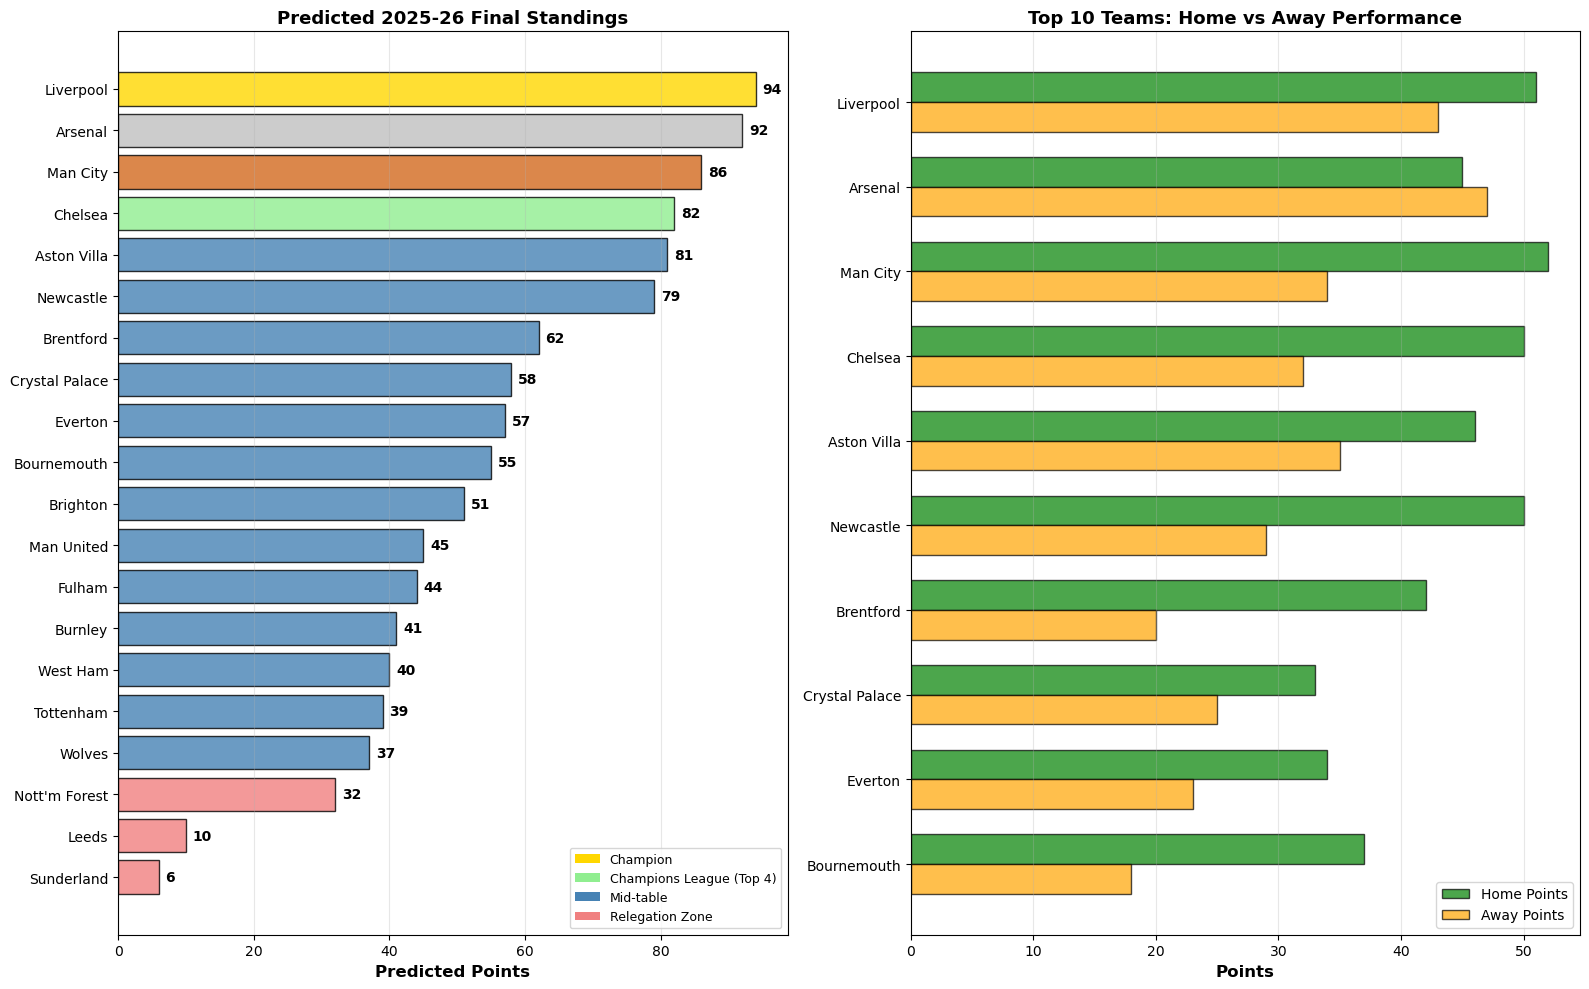

In [51]:
# Visualize predicted league table
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Predicted final standings
ax1 = axes[0]
colors_standing = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 
                   else 'lightgreen' if i < 4 else 'lightcoral' if i >= 17 else 'steelblue' 
                   for i in range(len(predicted_table))]

bars1 = ax1.barh(predicted_table['Team'], predicted_table['Points'], 
                 color=colors_standing, edgecolor='black', alpha=0.8)
ax1.set_xlabel('Predicted Points', fontweight='bold', fontsize=12)
ax1.set_title('Predicted 2025-26 Final Standings', fontweight='bold', fontsize=13)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add points labels
for bar in bars1:
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gold', label='Champion'),
    Patch(facecolor='lightgreen', label='Champions League (Top 4)'),
    Patch(facecolor='steelblue', label='Mid-table'),
    Patch(facecolor='lightcoral', label='Relegation Zone')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Home vs Away performance
ax2 = axes[1]
predicted_table['Home_Points'] = (predicted_table['Home_W'] * 3 + predicted_table['Home_D'])
predicted_table['Away_Points'] = (predicted_table['Away_W'] * 3 + predicted_table['Away_D'])

top10_teams = predicted_table.head(10)
x = np.arange(len(top10_teams))
width = 0.35

bars2 = ax2.barh(x - width/2, top10_teams['Home_Points'], width, 
                 label='Home Points', color='green', alpha=0.7, edgecolor='black')
bars3 = ax2.barh(x + width/2, top10_teams['Away_Points'], width,
                 label='Away Points', color='orange', alpha=0.7, edgecolor='black')

ax2.set_yticks(x)
ax2.set_yticklabels(top10_teams['Team'])
ax2.set_xlabel('Points', fontweight='bold', fontsize=12)
ax2.set_title('Top 10 Teams: Home vs Away Performance', fontweight='bold', fontsize=13)
ax2.invert_yaxis()
ax2.legend(fontsize=10)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [52]:
# Save all 380 fixture predictions to CSV
output_path = Path('../data/processed/2025-26_match_predictions.csv')
if not output_path.parent.exists():
    output_path = Path('data/processed/2025-26_match_predictions.csv')

# Prepare detailed fixture predictions
fixtures_export = fixtures_df[['HomeTeam', 'AwayTeam', 'Predicted_Outcome', 
                                'Home_Win_Prob', 'Draw_Prob', 'Away_Win_Prob', 
                                'Confidence']].copy()

# Add match numbers
fixtures_export.insert(0, 'Match_ID', range(1, len(fixtures_export) + 1))

# Sort by home team for easier viewing
fixtures_export = fixtures_export.sort_values(['HomeTeam', 'AwayTeam'])

# Save to CSV
fixtures_export.to_csv(output_path, index=False)
print(f"\n✅ All 380 match predictions saved to: {output_path}")
print(f"   File contains: Match ID, Teams, Predicted Outcome, Win/Draw Probabilities, Confidence")

# Display sample predictions for each team
print("\n" + "="*80)
print("SAMPLE PREDICTIONS BY TEAM (Home matches only)")
print("="*80)

for team in sorted(teams_list)[:5]:  # Show first 5 teams as examples
    team_home_fixtures = fixtures_export[fixtures_export['HomeTeam'] == team].head(3)
    print(f"\n{team} (showing 3 of 19 home matches):")
    print(team_home_fixtures[['AwayTeam', 'Predicted_Outcome', 'Confidence']].to_string(index=False))

print("\n" + "="*80)
print(f"📁 Complete fixture list with all {len(fixtures_export)} predictions available in CSV file")
print("="*80)


✅ All 380 match predictions saved to: ../data/processed/2025-26_match_predictions.csv
   File contains: Match ID, Teams, Predicted Outcome, Win/Draw Probabilities, Confidence

SAMPLE PREDICTIONS BY TEAM (Home matches only)

Arsenal (showing 3 of 19 home matches):
   AwayTeam Predicted_Outcome  Confidence
Aston Villa              Draw   43.154479
Bournemouth              Draw   46.344450
  Brentford              Draw   53.962451

Aston Villa (showing 3 of 19 home matches):
   AwayTeam Predicted_Outcome  Confidence
    Arsenal          Away Win   59.319164
Bournemouth              Draw   45.088653
  Brentford              Draw   45.046409

Bournemouth (showing 3 of 19 home matches):
   AwayTeam Predicted_Outcome  Confidence
    Arsenal          Away Win   56.460175
Aston Villa          Away Win   59.886965
  Brentford          Away Win   44.538320

Brentford (showing 3 of 19 home matches):
   AwayTeam Predicted_Outcome  Confidence
    Arsenal          Away Win   61.294085
Aston Villa   

In [ ]:
# Display complete fixture predictions for a specific team
print("\n" + "="*80)
print("COMPLETE FIXTURE PREDICTIONS - DETAILED VIEW")
print("="*80)

# Let user select a team (or show example)
example_team = sorted(teams_list)[0]  # First team alphabetically

team_all_fixtures = fixtures_export[
    (fixtures_export['HomeTeam'] == example_team) | 
    (fixtures_export['AwayTeam'] == example_team)
].copy()

# Add venue indicator
team_all_fixtures['Venue'] = team_all_fixtures.apply(
    lambda row: 'Home' if row['HomeTeam'] == example_team else 'Away', axis=1
)

team_all_fixtures['Opponent'] = team_all_fixtures.apply(
    lambda row: row['AwayTeam'] if row['HomeTeam'] == example_team else row['HomeTeam'], axis=1
)

print(f"\nAll 38 matches for {example_team}:")
print("-" * 80)

display_cols = ['Venue', 'Opponent', 'Predicted_Outcome', 'Confidence', 
                'Home_Win_Prob', 'Draw_Prob', 'Away_Win_Prob']

for idx, row in team_all_fixtures.iterrows():
    venue = row['Venue']
    opponent = row['Opponent']
    outcome = row['Predicted_Outcome']
    conf = row['Confidence']
    
    # Determine expected result from team's perspective
    if venue == 'Home':
        if outcome == 'Home Win':
            result = 'WIN'
        elif outcome == 'Draw':
            result = 'DRAW'
        else:
            result = 'LOSS'
    else:  # Away
        if outcome == 'Away Win':
            result = 'WIN'
        elif outcome == 'Draw':
            result = 'DRAW'
        else:
            result = 'LOSS'
    
    print(f"{venue:5} vs {opponent:20} → {result:4} ({conf:5.1f}% confidence)")

# Calculate expected points for this team
team_expected_points = predicted_table[predicted_table['Team'] == example_team]['Points'].values[0]
team_position = predicted_table[predicted_table['Team'] == example_team]['Position'].values[0]

print("-" * 80)
print(f"Expected Points: {team_expected_points} | Predicted Position: {team_position}")
print("="*80)

print("\n💡 TIP: Check the CSV file for predictions of all teams' fixtures")
print(f"   File: {output_path}")


COMPLETE FIXTURE PREDICTIONS - DETAILED VIEW

All 38 matches for Arsenal:
--------------------------------------------------------------------------------
Home  vs Aston Villa          → DRAW ( 43.2% confidence)
Home  vs Bournemouth          → DRAW ( 46.3% confidence)
Home  vs Brentford            → DRAW ( 54.0% confidence)
Home  vs Brighton             → DRAW ( 52.9% confidence)
Home  vs Burnley              → DRAW ( 51.2% confidence)
Home  vs Chelsea              → WIN  ( 52.0% confidence)
Home  vs Crystal Palace       → DRAW ( 49.3% confidence)
Home  vs Everton              → WIN  ( 59.4% confidence)
Home  vs Fulham               → WIN  ( 64.3% confidence)
Home  vs Leeds                → WIN  ( 76.5% confidence)
Home  vs Liverpool            → WIN  ( 63.4% confidence)
Home  vs Man City             → WIN  ( 71.1% confidence)
Home  vs Man United           → WIN  ( 82.1% confidence)
Home  vs Newcastle            → WIN  ( 84.1% confidence)
Home  vs Nott'm Forest        → WIN  ( 88.7% c

Exception ignored in: <function ResourceTracker.__del__ at 0x110c91bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x111065bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110c7dbc0>
Traceback (most recent call last